## Appello del 09 Gennaio 2015

In [19]:
#IMPORT
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import (train_test_split, cross_val_score)

# Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier

# Metrics
from sklearn.metrics import (accuracy_score, confusion_matrix)
from sklearn.metrics import confusion_matrix

# PreProcessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer

#Features Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

### Punto 1.1

In [20]:
"""
    Caricare il dataset e denominarlo con una variabile chiamata “dataset”
"""
path = 'wildlife0901.csv'
dataset = pd.read_csv(path, sep=';')
dataset.head()

,AC_CLASS,AC_MASS,NUM_ENGS,INCIDENT_MONTH,INCIDENT_YEAR,HEIGHT,SPEED,PHASE_OF_FLT,DAMAGE,BIRDS_STRUCK,SIZE,WARNED
0,A,1,1.0,9,2011,0,0,1,N,1,Small,N
1,A,1,1.0,5,2013,0,0,1,S,1,Large,N
2,A,1,1.0,9,2013,0,0,1,N,1,Small,Y
3,A,1,1.0,12,2013,0,0,1,N,1,Small,N
4,B,1,1.0,7,2010,0,0,1,N,1,Medium,Y


### Punto 1.2

In [3]:
"""
    Quanti sono gli incidenti che hanno coinvolto elicotteri?
    Quanti hanno coinvolto areoplani?
"""
num = dataset.groupby(['AC_CLASS'])['AC_CLASS'].size()
num_A = num['A']
num_B = num['B']
print("Elicotteri coinvolti: {}".format(num_A))
print("Aereoplani coinvolti: {}".format(num_B))

Elicotteri coinvolti: 15617
Aereoplani coinvolti: 482


### Punto 1.3

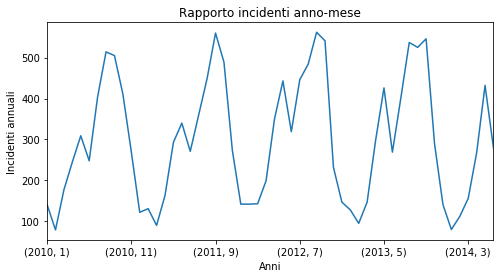

L'anno 2012 e il mese 9 si sono registrati il numero massimo di incidenti, pari a 562


In [4]:
"""
    Raggruppare gli incidenti per mesi e visualizzarli in un grafico. 
    Qual è il mese con il maggior numero di incidenti? 
"""
incident_year_month= dataset.groupby(['INCIDENT_YEAR','INCIDENT_MONTH'])['INCIDENT_MONTH'].count()
incident_year_month.plot(figsize = (8, 4), title = 'Rapporto incidenti anno-mese')
plt.ylabel("Incidenti annuali")
plt.xlabel("Anni")
plt.show()

# Prendo il numero massimo di incidenti e il mese e l'anno in cui si sono verificati
incidenti_max = incident_year_month.max()
year_max = incident_year_month.idxmax()
print('L\'anno {} e il mese {} si sono registrati il numero massimo di incidenti, pari a {}'
      .format(year_max[0], year_max[1], incidenti_max))

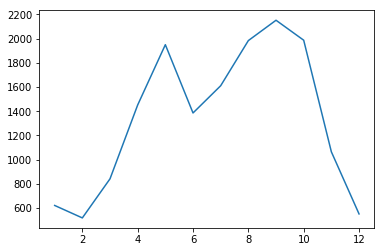

Il mese nel quale si sono registrati più incidenti è 9 con 2152 incidenti


In [5]:
"""
    Questo è un modo alternativo per calcolare il punto 1.2 basandosi solamente sui mesi
"""
incident_month = dataset['INCIDENT_MONTH'].value_counts().sort_index()
plt.plot(incident_month)
plt.show()
indicent_max = incident_month.max()
month_max = incident_month.idxmax()
print('Il mese nel quale si sono registrati più incidenti è {} con {} incidenti'.format(month_max, indicent_max))

### Punto 1.4

In [6]:
""" 
    Creare un nuovo dataset (chiamato “summary”) nel quale rappresentare sulle righe i mesi e
    sulle colonne gli anni. 
    E’ possibile individuare attraverso una rappresentazione grafica un trend 
    nella frequenza degli incidenti?
""" 
# Raggruppo il dataset per mesi ed anni
summary = dataset.groupby(['INCIDENT_MONTH', 'INCIDENT_YEAR']).size()
# Uso la funzione 'unstack' per ruotare l'indice 'INCIDENT_YEAR' e utilizzarlo come colonna
summary = summary.unstack(['INCIDENT_YEAR'])
print('Summary Dataset: ')
print(summary)

Summary Dataset: 
INCIDENT_YEAR    2010   2011   2012   2013   2014
INCIDENT_MONTH                                   
1               141.0  131.0  142.0  128.0   80.0
2                79.0   90.0  143.0   95.0  112.0
3               177.0  163.0  199.0  147.0  156.0
4               245.0  293.0  350.0  297.0  267.0
5               309.0  340.0  443.0  426.0  432.0
6               248.0  271.0  319.0  269.0  279.0
7               404.0  360.0  446.0  401.0    NaN
8               514.0  449.0  484.0  537.0    NaN
9               505.0  560.0  562.0  525.0    NaN
10              411.0  489.0  541.0  546.0    NaN
11              270.0  273.0  232.0  290.0    NaN
12              122.0  142.0  147.0  141.0    NaN


### Punto 2.1

In [32]:
"""
    Scikit-learn utilizza un array numpy per effettuare le proprie predizioni. Gli elementi 
    dell’array numpy devono essere delle stesso data type. E’ necessario pertanto trasformare i 
    dati del dataset per renderli utilizzabili con scikit.

    Trasformare i valori dei campi DAMAGE, SIZE, WARNED adottando i seguenti valori:
        * DAMAGE
            U = 0
            N = 1
            M = 3
            M?= 5
            S = 7
            D = 9
        *SIZE
            Small = 1
            Medium = 3
            Large = 5
            Unknown = 0
        *WARNED
            N = 0
            Y = 1
            Unknown = 3
    
"""
# Creo i dizionari per la sostituzione
dict_damage = {'U':'0', 'N':'1','M':'3','M?':'5', 'S':'7', 'D':'9'}
dict_size = {'Small':'1', 'Medium':'3', 'Large':'5', 'Unknown':'0'}
dict_warned = {'N':'0', 'Y':'1', 'Unknown':'3'}
dict_df = {'DAMAGE': dict_damage, 'SIZE': dict_size, 'WARNED': dict_warned}

# Per evitare problemi con le future esecuzioni copio il dataset in un nuovo Dataframe chiamato 'df_new'
df_new = dataset.copy()
# Sostituisco i valori
df_new.replace(dict_df)
# Print
print('*' * 100)
print("Trasformazione\n", dataset.head(5))
print('Valori \'DAMAGE\': {}'.format(df_new['DAMAGE'].unique()))
print('Valori \'SIZE\': {}'.format(df_new['SIZE'].unique()))
print('Valori \'WARNED\': {}'.format(df_new['WARNED'].unique()))

****************************************************************************************************
Trasformazione
   AC_CLASS  AC_MASS  NUM_ENGS  INCIDENT_MONTH  INCIDENT_YEAR  HEIGHT  SPEED  \
0        A        1       1.0               9           2011       0      0   
1        A        1       1.0               5           2013       0      0   
2        A        1       1.0               9           2013       0      0   
3        A        1       1.0              12           2013       0      0   
4        B        1       1.0               7           2010       0      0   

   PHASE_OF_FLT DAMAGE  BIRDS_STRUCK    SIZE WARNED  
0             1      N             1   Small      N  
1             1      S             1   Large      N  
2             1      N             1   Small      Y  
3             1      N             1   Small      N  
4             1      N             1  Medium      Y  
Valori 'DAMAGE': ['N' 'S' 'D' 'M' 'M?']
Valori 'SIZE': ['Small' 'Large' 'Medium' 'Un

In [33]:
"""
    Si poteva anche realizzare come:
"""
# Per evitare problemi con le future esecuzioni copio il dataset in un nuovo Dataframe chiamato 'df_new'
df_new = dataset.copy()
# Sostituisco i valori
df_new['DAMAGE'] = df_new['DAMAGE'].map(dict_damage)
df_new['SIZE'] = df_new['SIZE'].map(dict_size)
df_new['WARNED'] = df_new['WARNED'].map(dict_warned)
print("Trasformazione\n", dataset.head())

Trasformazione
   AC_CLASS  AC_MASS  NUM_ENGS  INCIDENT_MONTH  INCIDENT_YEAR  HEIGHT  SPEED  \
0        A        1       1.0               9           2011       0      0   
1        A        1       1.0               5           2013       0      0   
2        A        1       1.0               9           2013       0      0   
3        A        1       1.0              12           2013       0      0   
4        B        1       1.0               7           2010       0      0   

   PHASE_OF_FLT DAMAGE  BIRDS_STRUCK    SIZE WARNED  
0             1      N             1   Small      N  
1             1      S             1   Large      N  
2             1      N             1   Small      Y  
3             1      N             1   Small      N  
4             1      N             1  Medium      Y  


### Punto 2.2

In [34]:
"""
    Creare un nuovo dataset che consideri solo gli aeroplani e gli incidenti 
    che coinvolgono animali con una dimensione nota. Denominare il dataset  “data_air”. 
    In data_air eliminare poi l’attributo AC_CLASS divenuto irrilevante. 
"""
# Utilizzo il DataFrame 'df_new' modificato precedentemente e per evitare problemi lo copio in 'data_air' e poi
# modifico quest'ultimo
data_air = df_new.copy()
data_air = data_air[(dataset.AC_CLASS == 'A')]
data_air = data_air[(data_air.SIZE != '0')]
data_air = data_air.drop(['AC_CLASS'], axis = 1)
print('Data Air:\n', data_air.head())

# Per verificare la corretta esecuzioni controllo il numero di righe coinvolte
num_ac_class_A = df_new[(df_new['AC_CLASS'] != 'A')].shape[0]
num_size_0 = df_new[(df_new['SIZE'] == '0')].shape[0]
print('*' * 100)
print('Righe Dataset iniziale: {}'.format(df_new.shape[0]))
print('Nuova dimensione: {} (Non A:{}, Uguali a zero:{})'.format(data_air.shape[0],
                                                                 num_ac_class_A, num_size_0))

Data Air:
    AC_MASS  NUM_ENGS  INCIDENT_MONTH  INCIDENT_YEAR  HEIGHT  SPEED  \
0        1       1.0               9           2011       0      0   
1        1       1.0               5           2013       0      0   
2        1       1.0               9           2013       0      0   
3        1       1.0              12           2013       0      0   
8        2       2.0               9           2012       0      0   

   PHASE_OF_FLT DAMAGE  BIRDS_STRUCK SIZE WARNED  
0             1      1             1    1      0  
1             1      7             1    5      0  
2             1      1             1    1      1  
3             1      1             1    1      0  
8             1      1             1    3      3  
****************************************************************************************************
Righe Dataset iniziale: 16122
Nuova dimensione: 14842 (Non A:505, Uguali a zero:797)


### Punto 2.3

In [10]:
"""
    - Eliminare le righe che contengono almeno un element NaN
"""
# Solito discorso, copio
data_air_new = data_air.copy()
num_NaN = data_air_new.isnull().sum().sum()
data_air_new = data_air_new.dropna()
print("Si può notare l'eliminazione delle istante che contengono valori NaN dalla loro dimesione\n")
print("Con NaN {} senza {}".format(data_air.shape[0], data_air_new.shape[0]))
print('Num NaN: {}'.format(num_NaN))

Si può notare l'eliminazione delle istante che contengono valori NaN dalla loro dimesione

Con NaN 14842 senza 14789
Num NaN: 53


### Punto 2.4

In [11]:
"""
    Si vuole predire la dimensione dell’animale sulla base degli altri attributi 
    presenti nel dataset . Dividere “data_air” in modo che ¾ degli elementi siano contenuti 
    in un nuovo dataset “train” e ¼ nel dataset “test”.
    Valutare l’accuracy ottenuta con il modello BernoulliNB
    (from sklearn.naive_bayes import BernoulliNB)
"""
# Utilizzo il dataset creato precedentemente, solito discorso copio
dataset_bnb = data_air_new.copy()
Y = dataset_bnb['SIZE']
X = dataset_bnb.drop(['SIZE'], axis = 1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25)
print("Dimensioni:\nIniziale: {}\nTrain: {}\nTest: {}".format(dataset_bnb.shape[0], 
                                                             X_train.shape[0], X_test.shape[0]))
model_BNB = BernoulliNB()
# Fit
model_BNB.fit(X_train, Y_train)
# Score
score_BNB = model_BNB.score(X_test, Y_test)
print('*' * 100)
print("Accuracy: {:.04f}".format(score_BNB))

Dimensioni:
Iniziale: 14789
Train: 11091
Test: 3698
Accuracy: 0.7031


### Punto 2.5

In [12]:
"""
    Il valore di accuratezza ottenuto è abbastanza elevato, tuttavia, cosa si scopre analizzando la 
    confusion matrix?
"""
y_pred_BNB = model_BNB.predict(X_test)
confusion_matrix_BNB = confusion_matrix(Y_test, y_pred_BNB)
print("Confusion matrix:\n{}".format(confusion_matrix_BNB))

Confusion matrix:
[[2600    1    0]
 [ 801    0    0]
 [ 293    3    0]]


### Punto 2.6

In [13]:
"""
    Se si utilizza un modello basato su Decision Tree che valore di accuratezza si ottiene? 
    Cambia qualcosa nella confusion matrix?
"""
model_DT= DecisionTreeClassifier()
# Fit
model_DT.fit(X_train, Y_train)
# Score Decision Tree
score_DT = model_DT.score(X_test, Y_test)
# Predict Decision Tree
y_pred_DT = model_DT.predict(X_test)
# Confusion Matrix Decision Tree
confusion_matrix_DT = confusion_matrix(Y_test, y_pred_DT)
# Print
print("Accuracy: {:.04f}".format(score_DT))
print("Confusion matrix:\n{}".format(confusion_matrix_DT))

Accuracy: 0.6044
Confusion matrix:
[[1933  523  145]
 [ 506  221   74]
 [ 122   93   81]]


### Punto 2.7

In [14]:
"""
    Si analizzi il dataset “data_air” e si crei un nuovo training set “bilanciato” composto
    cioè di ¾ delle istanze aventi valore di SIZE = 1 (Small), ¾ delle istanze aventi valore di SIZE =3 
    (Medium), ¾ delle istanze aventi valore di SIZE = 5 (Large) e aventi come test set il rimanente 
    delle istanze. Come cambia l’accuratezza considerando sempre un modello basato su Decision Tree? 
    Cambia qualcosa nella confusion matrix?
"""
# Utilizzo 'data_air_new' nel quale non sono presenti i valori di SIZE uguale a 0 e considera solo gli aereoplani
# Prendo separatamente le istanze per 'SIZE' uguale a 1, 3 e 5
data_air_size_one = data_air_new[data_air_new.SIZE == '1']
data_air_size_three = data_air_new[data_air_new.SIZE == '3']
data_air_size_five = data_air_new[data_air_new.SIZE == '5']
# Creo il training set
X_train_one, _ = train_test_split(data_air_size_one, test_size = 0.25)
X_train_three, _ = train_test_split(data_air_size_three, test_size = 0.25)
X_train_five, _ = train_test_split(data_air_size_five, test_size = 0.25)
# Verifico le dimensioni
print('Numero righe iniziali: ONE: {} - THREE:{} - FIVE:{}'.format(data_air_size_one.shape[0],
                                                                   data_air_size_three.shape[0],
                                                                   data_air_size_five.shape[0]))
print('Numero righe Train: ONE: {} - THREE:{} - FIVE:{}'.format(X_train_one.shape[0], X_train_three.shape[0],
                                                                X_train_five.shape[0]))


#Creo il nuovo dataset
dataset_balanced = X_train_one.append(X_train_three).append(X_train_five)

# Calcolo i nuovi X e Y
Y_bal = dataset_balanced['SIZE']
X_bal = dataset_balanced.drop(['SIZE'], axis = 1)
X_bal_train, X_bal_test, Y_bal_train, Y_bal_test = train_test_split(X_bal, Y_bal, test_size = 0.25)

model_DT.fit(X_bal_train, Y_bal_train)
# Calcolo l'accuracy e la confusion_matrix

score_bal_DT = model_DT.score(X_bal_test, Y_bal_test)
y_pred_bal_DT = model_DT.predict(X_bal_test)

confusion_matrix_bal_DT = confusion_matrix(Y_bal_test, y_pred_bal_DT)

# Print
print("Accuracy DT Balanced: {:.04f}".format(score_bal_DT))
print("Confusion matrix DT Balanced:\n{}".format(confusion_matrix_bal_DT))

Numero righe iniziali: ONE: 10325 - THREE:3304 - FIVE:1160
Numero righe Train: ONE: 7743 - THREE:2478 - FIVE:870
Accuracy DT Balanced: 0.6091
Confusion matrix DT Balanced:
[[1439  411   89]
 [ 370  190   61]
 [  92   61   60]]


###  PUNTO 2.8

In [29]:
"""
    Si consideri un nuovo dataset ottenuto attraverso una variazione a piacere del
    precedente e si analizzi l’accuratezza ottenuta con un modello basato su Decision Tree. 
    Che valore si ottiene? 
"""
# Lavoro su un nuovo DataFrame copia di X
X_zip = X.copy()

# Rescale 'SPEED' tra 0 e 5
scaler = MinMaxScaler(feature_range = (0, 5))
X_zip['SPEED'] = scaler.fit_transform(X_zip[['SPEED']])

# Raggruppo 'INCIDENT_MONTH' in 5 chunks
num_chunks = 5
name_chunks = [1, 2, 3, 4, 5]
chunks = pd.qcut(X_zip['INCIDENT_MONTH'],q = num_chunks, labels = name_chunks)
X_zip['IM_CHUNKS'] = chunks.values

# Creo una colonna se l'incidente è avvenuto sopra o sotto l'altezza media
mean_height = X_zip['HEIGHT'].mean()
X_zip['MEAN_HEIGHT'] = np.where(X_zip['HEIGHT'] > mean_height, '1' , '0')

# Cerco le features più importanti utilizzando X e Y calcolati al punto 2.4
selector = SelectKBest(score_func = chi2, k = 5)
X_zip = selector.fit_transform(X_zip, Y)

# Split dataset
X_train_zip, X_test_zip, Y_train_zip, Y_test_zip = train_test_split(X_zip, Y, test_size = 0.25)

# Fit and Predict
model_DT.fit(X_train_zip, Y_train_zip)
score = model_DT.score(X_test_zip, Y_test_zip)
y_pred_zip = model_DT.predict(X_test_zip)
#Print
print('Accuracy: {:0.3f}'.format(score))
confusion_matrix_zip = confusion_matrix(Y_test_zip, y_pred_zip)
print('Confusione matrix:\n {}'.format(confusion_matrix_zip))

Accuracy: 0.713
Confusione matrix:
 [[2488   79   23]
 [ 702   94   34]
 [ 170   52   56]]


### Punto 2.9

In [16]:
"""
    Che valore di accuratezza si ottiene con un 5 Fold cross validation e un modello basato su Decision Tree
"""
num_folds = 5
scores = cross_val_score(model_DT, X, Y, cv = num_folds)
print('Accuracy {:.04f} ({:.04f})'.format(scores.mean(), scores.std()))

Accuracy 0.4201 (0.1707)
